In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u
from scipy.stats import ttest_ind

# 讀取資料
df= pd.read_csv("https://docs.google.com/spreadsheets/d/1Z8nrGXpE4q08e3nQZ-HB0sv4no3-gmZrTFQE3CJmiPU/export?format=csv")


#清除空白資料
df_cleaned = df.dropna(subset=['ra', 'dec', 'pmra', 'pmdec', 'parallax'])
ra, dec, pmra, pmdec, parallax = df_cleaned['ra'].values, df_cleaned['dec'].values, df_cleaned['pmra'].values, df_cleaned['pmdec'].values, df_cleaned['parallax'].values

ra = df_cleaned['ra'].values
dec = df_cleaned['dec'].values
pmra = df_cleaned['pmra'].values
pmdec = df_cleaned['pmdec'].values
parallax = df_cleaned['parallax'].values

distance = 1000/parallax

columns_to_clean = ['ra', 'dec', 'pmra', 'pmdec', 'parallax']
for col in columns_to_clean:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, distance=distance * u.pc, frame='icrs')
galactocentric = coord.transform_to(Galactocentric())
X, Y, Z = galactocentric.x.to(u.kpc).value, galactocentric.y.to(u.kpc).value, galactocentric.z.to(u.kpc).value
df_cleaned['X'] = X
df_cleaned['Y'] = Y
df_cleaned['Z'] = Z
df_cleaned['distance_to_gc'] = np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2 + df_cleaned['Z']**2)
max_range = np.max([np.max(np.abs(X)), np.max(np.abs(Y)), np.max(np.abs(Z))])

# 定義位置條件和標籤
conditions = [
    (np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2 + df_cleaned['Z']**2) < 3),  #核球
    (np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2) < 21) & (np.abs(df_cleaned['Z']) <  1.35),  #銀盤
    (np.abs(df_cleaned['Z']) > 1.35) | (np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2) > 21),  #銀暈
]
choices = ['Bulge', 'Disk', 'Halo']


# 新增 'Location' 欄位
df_cleaned['Location'] = np.select(conditions, choices, default='Unknown')

bulge = df_cleaned[(df_cleaned['Location'] == 'Bulge') & df_cleaned['X'].notna()]
disk = df_cleaned[(df_cleaned['Location'] == 'Disk') & df_cleaned['X'].notna()]
halo = df_cleaned[(df_cleaned['Location'] == 'Halo') & df_cleaned['X'].notna()]

# 繪製 3D 散點圖(色階)

df_cleaned['N'] = pd.to_numeric(df_cleaned['N'], errors='coerce')

feh_min = df_cleaned['N'].quantile(0.05)
feh_max = df_cleaned['N'].quantile(0.95)

df_cleaned['hover_text'] = df_cleaned.apply(lambda row:
        f"Name: {row['Name']}<br>" +
        f"Distance to GC: {row['distance_to_gc']:.2f} kpc<br>" +
        f"Location: {row['Location']}", axis=1)

fig_metallicity = go.Figure()

fig_metallicity.add_trace(go.Scatter3d(
    x=df_cleaned['X'],
    y=df_cleaned['Y'],
    z=df_cleaned['Z'],
    mode='markers',
    marker=dict(
        size=6,
        color=df_cleaned['N'],
        colorscale='Viridis_r',
        cmin=feh_min,
        cmax=feh_max,
        colorbar=dict(
            title='N',
            tickvals=np.linspace(feh_min, feh_max, num=6),
            ticktext=[f"{val:.2f}" for val in np.linspace(feh_min, feh_max, num=6)],
            len=0.8,
            thickness=20,
            x=1.1
        ),
        opacity=0.7
    ),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name="Star Clusters"
))

earth_x = -8.122
earth_y = 0
earth_z = 0.027
fig_metallicity.add_trace(go.Scatter3d(
    x=[earth_x],
    y=[earth_y],
    z=[earth_z],
    mode='markers+text',
    marker=dict(
        size=10,
        color='navy',
        opacity=1
    ),
    text=["Earth"],
    textposition="bottom center",
    name="Earth"
))


fig_metallicity.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers+text',
    marker=dict(
        size=10,
        color='crimson',
        opacity=1
    ),
    text=["Galactic Core"],
    textposition="bottom center",
    name="Galactic Core",
    legendgroup='Galactic Core',
    showlegend=True
))


fig_metallicity.update_layout(
    title='星團分布 (銀心座標系) - N 色階',
    scene=dict(
        xaxis=dict(range=[-max_range, max_range], title='X (kpc)'),
        yaxis=dict(range=[-max_range, max_range], title='Y (kpc)'),
        zaxis=dict(range=[-max_range, max_range], title='Z (kpc)'),
        aspectmode='cube',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
    showlegend=True
)

fig_metallicity.show()

#繪製 3D 散點圖(以100和400為分界)
# 設定顏色條件
small_cluster = df_cleaned[df_cleaned['N'] < 400]
large_cluster = df_cleaned[df_cleaned['N'] > 400]

# 計算最大範圍
max_range = np.max([np.max(np.abs(df_cleaned['X'])), np.max(np.abs(df_cleaned['Y'])), np.max(np.abs(df_cleaned['Z']))])

#繪製 3D 散點圖(以100和400為分界)
# 設定顏色條件
small_cluster = df_cleaned[df_cleaned['N'] < 100]
middle_cluster = df_cleaned[(df_cleaned['N'] > 100) & (df_cleaned['N'] < 400)]
large_cluster = df_cleaned[df_cleaned['N'] > 400]

# 計算最大範圍
max_range = np.max([np.max(np.abs(df_cleaned['X'])), np.max(np.abs(df_cleaned['Y'])), np.max(np.abs(df_cleaned['Z']))])

# 建立 3D 圖表
fig = go.Figure()

# N < 100
fig.add_trace(go.Scatter3d(
    x=small_cluster['X'],
    y=small_cluster['Y'],
    z=small_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='purple', opacity=0.7),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name='N < 100'
))

fig.add_trace(go.Scatter3d(
    x=middle_cluster['X'],
    y=middle_cluster['Y'],
    z=middle_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='deepskyblue', opacity=0.7),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name="100 < N < 400"
))

# N > 400
fig.add_trace(go.Scatter3d(
    x=large_cluster['X'],
    y=large_cluster['Y'],
    z=large_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='orange', opacity=0.7),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name="N > 400"
))
earth_x = -8.122
earth_y = 0
earth_z = 0.027
fig.add_trace(go.Scatter3d(
    x=[earth_x],
    y=[earth_y],
    z=[earth_z],
    mode='markers+text',
    marker=dict(
        size=10,
        color='navy',
        opacity=1
    ),
    text=["Earth"],
    textposition="bottom center",
    name="Earth"
))


fig.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers+text',
    marker=dict(
        size=10,
        color='crimson',
        opacity=1
    ),
    text=["Galactic Core"],
    textposition="bottom center",
    name="Galactic Core",
    legendgroup='Galactic Core',
    showlegend=True
))

fig.update_layout(
    title='星團分布 (銀心座標系) - 以100與400顆為分界',
    scene=dict(
        xaxis=dict(range=[-max_range, max_range], title='X (kpc)'),
        yaxis=dict(range=[-max_range, max_range], title='Y (kpc)'),
        zaxis=dict(range=[-max_range, max_range], title='Z (kpc)'),
        aspectmode='cube',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
    showlegend=True
)
fig.show()
#output_csv_path = '疏散星團分布_GC20.csv'
#df_cleaned.to_csv(output_csv_path, index=False)

#from google.colab import files
#files.download('疏散星團分布_GC20.csv')

fig.write_html("疏散星團分布_GC20.html")
from google.colab import files
files.download("疏散星團分布_GC20.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install bokeh

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt



# 定義地球的位置
earth_x, earth_y, earth_z = -8.122, 0, 0.027

# 計算每個星團到地球的距離
df_cleaned['earth_distance'] = np.sqrt(
    (df_cleaned['X'] - earth_x) ** 2 +
    (df_cleaned['Y'] - earth_y) ** 2 +
    (df_cleaned['Z'] - earth_z) ** 2
)

# 篩選在地球附近的星團（假設半徑為 2 kpc）
nearby_threshold = 5 # kpc
df_near_earth = df_cleaned[df_cleaned['earth_distance'] <= nearby_threshold]
df_near_earth['z_distance'] = df_near_earth['Z'].abs()
# 根據在地球附近的星團進行分組
small_cluster = df_near_earth[df_near_earth['N'] < 400]
large_cluster = df_near_earth[df_near_earth['N'] > 400]

# 計算平均值
small_mean = small_cluster['z_distance'].mean()
large_mean = large_cluster['z_distance'].mean()

# 計算中位數
small_median = small_cluster['z_distance'].median()
large_median = large_cluster['z_distance'].median()

# 計算中位數的標準誤差 (IQR / sqrt(N))
small_iqr = small_cluster['z_distance'].quantile(0.75) - small_cluster['z_distance'].quantile(0.25)
large_iqr = large_cluster['z_distance'].quantile(0.75) - large_cluster['z_distance'].quantile(0.25)

small_median_error = small_iqr / np.sqrt(len(small_cluster))
large_median_error = large_iqr / np.sqrt(len(large_cluster))

# 進行 T 檢定（基於中位數和誤差範圍）
t_stat_median, p_value_median = ttest_ind(
    np.random.normal(small_median, small_median_error, len(small_cluster)),
    np.random.normal(large_median, large_median_error, len(large_cluster)),
    equal_var=False
)

# 輸出統計結果
stats_summary = pd.DataFrame({
    'Cluster Size': ['N < 400', 'N >= 400'],
    'Median Z Distance (pc)': [small_median, large_median],
    'Median Standard Error (pc)': [small_median_error, large_median_error],
    'Mean Z Distance':[small_mean, large_mean]
})

t_test_results = pd.DataFrame({
    'Test Type': ['Median T-Test'],
    'T-Statistic': [t_stat_median],
    'P-Value': [p_value_median]
})

# 計算最大範圍
max_range = np.max([np.max(np.abs(df_near_earth['X'])),np.max(np.abs(df_near_earth['Y'])),np.max(np.abs(df_near_earth['Z']))])

# 建立 3D 圖表
df_near_earth['N'] = pd.to_numeric(df_near_earth['N'], errors='coerce')

feh_min = df_near_earth['N'].quantile(0.05)
feh_max = df_near_earth['N'].quantile(0.95)

fig_metallicity = go.Figure()

fig_metallicity.add_trace(go.Scatter3d(
    x=df_near_earth['X'],
    y=df_near_earth['Y'],
    z=df_near_earth['Z'],
    mode='markers',
    marker=dict(
        size=6,
        color=df_near_earth['N'],
        colorscale='Viridis_r',
        cmin=feh_min,
        cmax=feh_max,
        colorbar=dict(
            title='N',
            tickvals=np.linspace(feh_min, feh_max, num=6),
            ticktext=[f"{val:.2f}" for val in np.linspace(feh_min, feh_max, num=6)],
            len=0.8,
            thickness=20,
            x=1.1
        ),
        opacity=0.7
    ),
    name='Star Clusters'
))

earth_x = -8.122
earth_y = 0
earth_z = 0.027
fig_metallicity.add_trace(go.Scatter3d(
    x=[earth_x],
    y=[earth_y],
    z=[earth_z],
    mode='markers+text',
    marker=dict(
        size=10,
        color='navy',
        opacity=1
    ),
    text=["Earth"],
    textposition="bottom center",
    name="Earth"
))


fig_metallicity.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers+text',
    marker=dict(
        size=10,
        color='crimson',
        opacity=1
    ),
    text=["Galactic Core"],
    textposition="bottom center",
    name="Galactic Core",
    legendgroup='Galactic Core',
    showlegend=True
))


fig_metallicity.update_layout(
    title='星團分布 (銀心座標系) - N 色階',
    scene=dict(
        xaxis=dict(range=[-max_range, max_range], title='X (kpc)'),
        yaxis=dict(range=[-max_range, max_range], title='Y (kpc)'),
        zaxis=dict(range=[-max_range, max_range], title='Z (kpc)'),
        aspectmode='cube',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
    showlegend=True
)

fig_metallicity.show()


fig = go.Figure()

# N < 400
fig.add_trace(go.Scatter3d(
    x=small_cluster['X'],
    y=small_cluster['Y'],
    z=small_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='orange', opacity=0.7),
    name='N < 400'
))

# N > 400
fig.add_trace(go.Scatter3d(
    x=large_cluster['X'],
    y=large_cluster['Y'],
    z=large_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='purple', opacity=0.7),
    name='N > 400'
))

earth_x = -8.122
earth_y = 0
earth_z = 0.027
fig.add_trace(go.Scatter3d(
    x=[earth_x],
    y=[earth_y],
    z=[earth_z],
    mode='markers+text',
    marker=dict(
        size=10,
        color='navy',
        opacity=1
    ),
    text=["Earth"],
    textposition="bottom center",
    name="Earth"
))

fig.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers+text',
    marker=dict(
        size=10,
        color='crimson',
        opacity=1
    ),
    text=["Galactic Core"],
    textposition="bottom center",
    name="Galactic Core",
    legendgroup='Galactic Core',
    showlegend=True
))

fig.update_layout(
    title='星團分布 (銀心座標系) - 以100與400顆為分界',
    scene=dict(
        xaxis=dict(range=[-max_range, max_range], title='X (kpc)'),
        yaxis=dict(range=[-max_range, max_range], title='Y (kpc)'),
        zaxis=dict(range=[-max_range, max_range], title='Z (kpc)'),
        aspectmode='cube',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
    showlegend=True
)

fig.show()

print("Z Distance Statistics:")
print(stats_summary)
print("\nT-Test Results:")
print(t_test_results)

output_csv_path = '疏散星團分布_GC20.csv'
df_cleaned.to_csv(output_csv_path, index=False)

from google.colab import files
files.download('疏散星團分布_GC20.csv')

<ipython-input-13-3a6ee10924be>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-3a6ee10924be>:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Z Distance Statistics:
  Cluster Size  Median Z Distance (pc)  Median Standard Error (pc)  \
0      N < 400                0.067629                    0.002606   
1     N >= 400                0.086520                    0.011397   

   Mean Z Distance  
0         0.092358  
1         0.161426  

T-Test Results:
       Test Type  T-Statistic       P-Value
0  Median T-Test   -15.877637  9.106484e-31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

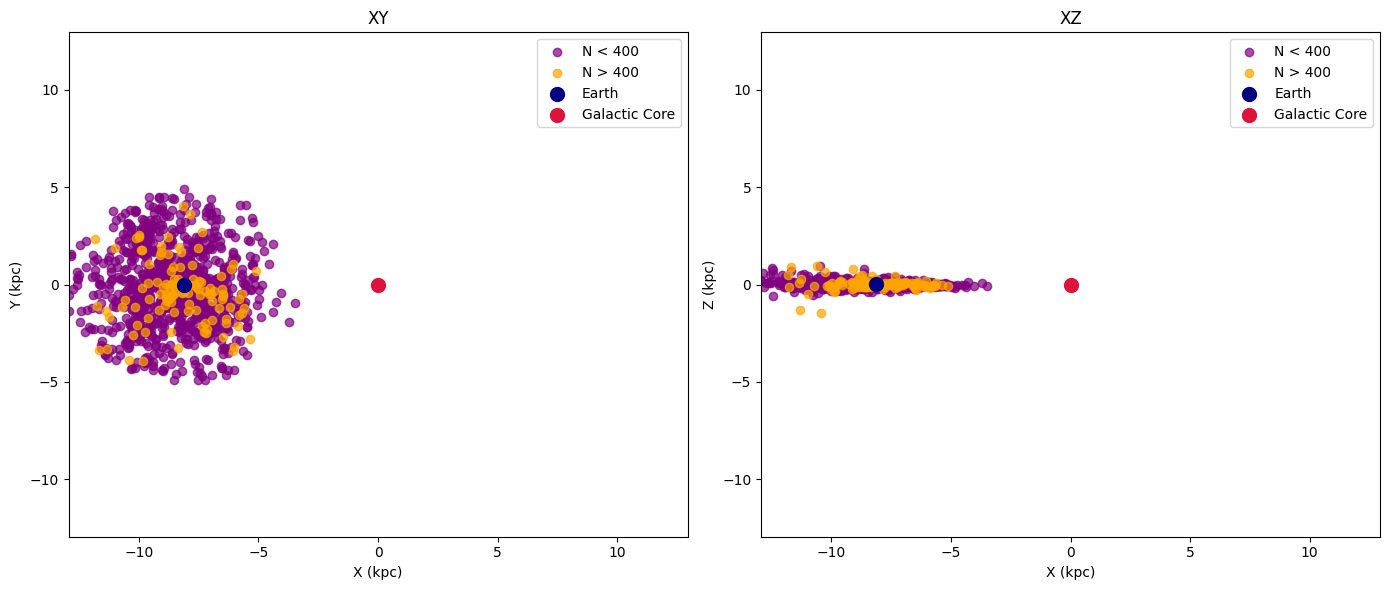

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定義地球的位置
earth_x, earth_y, earth_z = -8.122, 0, 0.027

# 計算每個星團到地球的距離
df_cleaned['earth_distance'] = np.sqrt(
    (df_cleaned['X'] - earth_x) ** 2 +
    (df_cleaned['Y'] - earth_y) ** 2 +
    (df_cleaned['Z'] - earth_z) ** 2
)

# 篩選在地球附近的星團（假設半徑為 5 kpc）
nearby_threshold = 5  # kpc
df_near_earth = df_cleaned[df_cleaned['earth_distance'] <= nearby_threshold]

# 根據星團大小分類
small_cluster = df_near_earth[df_near_earth['N'] < 400]
large_cluster = df_near_earth[df_near_earth['N'] > 400]

# 計算最大範圍
max_range = np.max([
    np.max(np.abs(df_near_earth['X'])),
    np.max(np.abs(df_near_earth['Y'])),
    np.max(np.abs(df_near_earth['Z']))
])

# 設定圖表大小
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ======= XY 平面投影 =======
axes[0].scatter(small_cluster['X'], small_cluster['Y'], color='purple', label='N < 400', alpha=0.7)
axes[0].scatter(large_cluster['X'], large_cluster['Y'], color='orange', label='N > 400', alpha=0.7)
axes[0].scatter(earth_x, earth_y, color='navy', s=100, label='Earth')
axes[0].scatter(0, 0, color='crimson', s=100, label='Galactic Core')
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')
axes[0].set_xlim(-max_range, max_range)
axes[0].set_ylim(-max_range, max_range)
axes[0].set_title('XY')
axes[0].legend()

# ======= XZ 平面投影 =======
axes[1].scatter(small_cluster['X'], small_cluster['Z'], color='purple', label='N < 400', alpha=0.7)
axes[1].scatter(large_cluster['X'], large_cluster['Z'], color='orange', label='N > 400', alpha=0.7)
axes[1].scatter(earth_x, earth_z, color='navy', s=100, label='Earth')
axes[1].scatter(0, 0, color='crimson', s=100, label='Galactic Core')
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
axes[1].set_xlim(-max_range, max_range)
axes[1].set_ylim(-max_range, max_range)
axes[1].set_title('XZ')
axes[1].legend()

# 顯示圖表
plt.tight_layout()
plt.show()


<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 26143 (\N{CJK UNIFIED IDEOGRAPH-661F}) missing from font(s) DejaVu Sans.

<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 22296 (\N{CJK UNIFIED IDEOGRAPH-5718}) missing from font(s) DejaVu Sans.

<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.

<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.

<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.

<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.

<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.

<ipython-input-7-0536019144a4>:62: UserWarning:

Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) mis

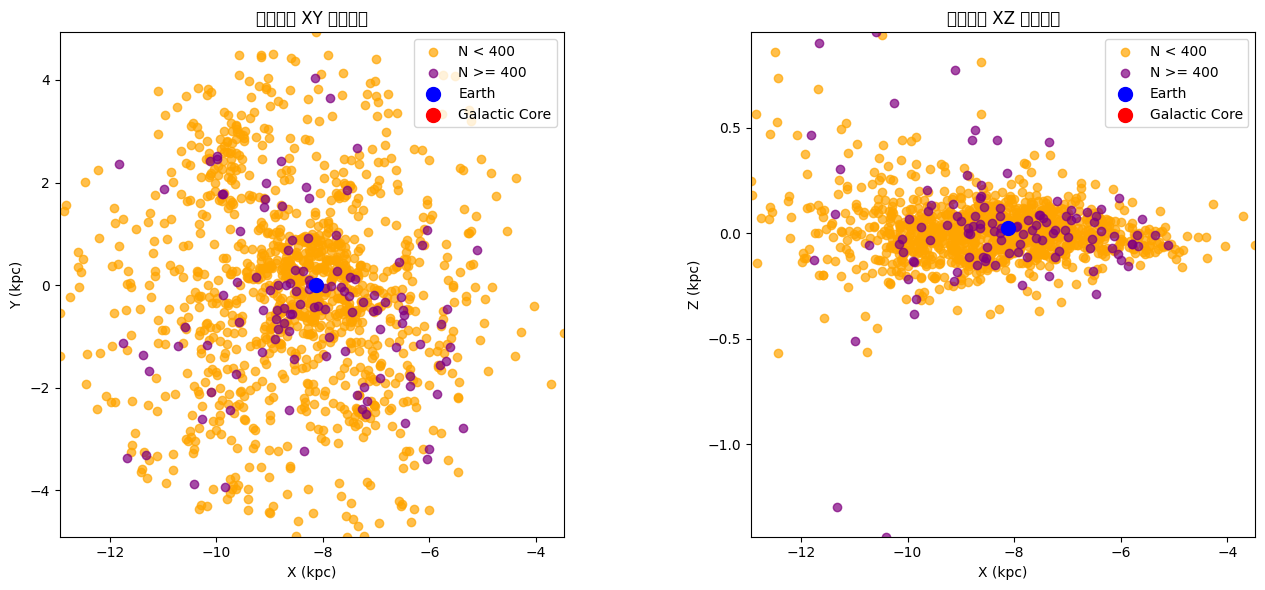

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 設定地球位置
earth_x, earth_y, earth_z = -8.122, 0, 0.027

# 計算每個星團到地球的距離
df_cleaned['earth_distance'] = np.sqrt(
    (df_cleaned['X'] - earth_x) ** 2 +
    (df_cleaned['Y'] - earth_y) ** 2 +
    (df_cleaned['Z'] - earth_z) ** 2
)

# 篩選在地球附近的星團（假設半徑為 5 kpc）
nearby_threshold = 5  # kpc
df_near_earth = df_cleaned[df_cleaned['earth_distance'] <= nearby_threshold]

# 根據星團大小分類
small_cluster = df_near_earth[df_near_earth['N'] < 400]
large_cluster = df_near_earth[df_near_earth['N'] >= 400]

# 設定圖表大小
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 計算 XY 和 XZ 平面的範圍
x_min, x_max = df_near_earth['X'].min(), df_near_earth['X'].max()
y_min, y_max = df_near_earth['Y'].min(), df_near_earth['Y'].max()
z_min, z_max = df_near_earth['Z'].min(), df_near_earth['Z'].max()

# 計算 XY 和 XZ 平面的比例
xy_aspect = (x_max - x_min) / (y_max - y_min) if (y_max - y_min) != 0 else 1
xz_aspect = (x_max - x_min) / (z_max - z_min) if (z_max - z_min) != 0 else 1

# ======= XY 平面投影 =======
axes[0].scatter(small_cluster['X'], small_cluster['Y'], color='orange', label='N < 400', alpha=0.7)
axes[0].scatter(large_cluster['X'], large_cluster['Y'], color='purple', label='N >= 400', alpha=0.7)
axes[0].scatter(earth_x, earth_y, color='blue', s=100, label='Earth')
axes[0].scatter(0, 0, color='red', s=100, label='Galactic Core')  # 銀河中心
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_aspect(aspect=xy_aspect)
axes[0].set_title('星團分布 XY 平面投影')
axes[0].legend()

# ======= XZ 平面投影 =======
axes[1].scatter(small_cluster['X'], small_cluster['Z'], color='orange', label='N < 400', alpha=0.7)
axes[1].scatter(large_cluster['X'], large_cluster['Z'], color='purple', label='N >= 400', alpha=0.7)
axes[1].scatter(earth_x, earth_z, color='blue', s=100, label='Earth')
axes[1].scatter(0, 0, color='red', s=100, label='Galactic Core')  # 銀河中心
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(z_min, z_max)
axes[1].set_aspect(aspect=xz_aspect)
axes[1].set_title('星團分布 XZ 平面投影')
axes[1].legend()

# 顯示圖表
plt.tight_layout()
plt.show()
